In [1]:
# import os
# import tensorflow as tf

# # Set CUDA device order and visible devices
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# # Set the device
# device = '/cpu:0'
# if tf.config.experimental.list_physical_devices('GPU'):
#     try:
#         # Restrict TensorFlow to only use the second GPU
#         gpus = tf.config.experimental.list_physical_devices('GPU')
#         if gpus:
#             tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#             device = '/gpu:0'
#     except RuntimeError as e:
#         print(e)

# print("device", device)


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1","/gpu:2"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

2024-10-06 19:01:30.669379: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 19:01:30.684982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 19:01:30.698653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 19:01:30.702771: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 19:01:30.715931: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


2024-10-06 19:01:36.134838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:45:00.0, compute capability: 8.0
2024-10-06 19:01:36.136403: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:46:00.0, compute capability: 8.0
2024-10-06 19:01:36.137855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79194 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:49:00.0, compute capability: 8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [3]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='x')  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / 64

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [4]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 64, 
                transposed_midpoints_corrected[:, :, 1] * 64, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


my NEW model

In [5]:
# from tensorflow.keras import layers, regularizers

# class ModelBuilder:
#     def __init__(self, input_shape=(64, 64, 1), num_classes=3, num_coordinates=2, learning_rate=3e-5, weights_path=None, l2_reg=0.001):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#         self.num_coordinates = num_coordinates
#         self.learning_rate = learning_rate
#         self.l2_reg = l2_reg
#         self.model = self.build_model()

#         # Load weights if a path is provided
#         if weights_path is not None:
#             self.model.load_weights(weights_path)

#         self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
#         # self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

#     def build_model(self):
#         l2 = regularizers.l2(self.l2_reg)
        
#         x_input = layers.Input(shape=self.input_shape)
        
#         # First branch
#         x_1 = layers.Conv2D(64, kernel_size=6, strides=1, padding='same', activation='relu')(x_input)
#         x_1 = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(x_1)
#         x_1 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(x_1)
#         x_1 = layers.Conv2D(16, kernel_size=3, strides=3, padding='same', activation='relu', kernel_regularizer=l2)(x_1)
#         # x_1 = layers.Dropout(0.1)(x_1)
#         # x_1 = layers.BatchNormalization()(x_1)

#         # Second branch
#         x_2 = layers.Conv2D(32, kernel_size=8, strides=3, padding='same', activation='relu')(x_input)
#         x_2 = layers.Conv2D(64, kernel_size=4, strides=1, padding='same', activation='relu')(x_2)
#         x_2 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2)(x_2)
#         # x_2 = layers.Dropout(0.1)(x_2)
#         # x_2 = layers.BatchNormalization()(x_2)

#         # Concatenate branches
#         x_3 = layers.concatenate([x_1, x_2])
#         x_3 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(x_3)
#         x_3 = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(x_3)
#         x_3 = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2)(x_3)
#         # x_3 = layers.Dropout(0.1)(x_3)
#         # x_3 = layers.BatchNormalization()(x_3)

#         # Third branch
#         x_4 = layers.Conv2D(64, kernel_size=19, strides=5, padding='same', activation='relu', kernel_regularizer=l2)(x_input)
        
#         # Flatten and concatenate
#         x_3 = layers.Flatten()(x_3)
#         x_4 = layers.Flatten()(x_4)
#         x = layers.Concatenate()([x_3, x_4])

#         # Dense layers with L2 regularization
#         x = layers.Dense(256, activation='relu', kernel_regularizer=l2)(x)
#         # x = layers.Dropout(0.1)(x)

#         # Output layer for midpoints
#         x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
#         x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
#         return tf.keras.models.Model(x_input, x_midpoints_reshape)

#     def compile_model(self, loss_function):
#         self.model.compile(optimizer=self.optimizer, loss=loss_function)

#     def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
#         history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
#         return history


In [5]:

from tensorflow.keras import layers, regularizers


class ModelBuilder:
    def __init__(self, input_shape=(64, 64, 1), num_classes=13, num_coordinates=2, learning_rate=1e-3, weights_path=None,l1_reg=0.001,l2_reg =0.01):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

    def build_model(self):
        
        l1 = regularizers.l1(self.l1_reg)
        l2 = regularizers.l2(self.l2_reg)

    
        x_input = layers.Input(shape=self.input_shape)
        
        
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        # x = layers.Dropout(0.2)(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        # x = layers.Dropout(0.2)(x)
        x = layers.BatchNormalization()(x)
        
        
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.3)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.3)(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.2)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='linear', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [7]:
np.max(train_midpoints)

NameError: name 'train_midpoints' is not defined

In [6]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_Mixed_13.h5'             
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/50KFixed-index6_13.h5'
data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


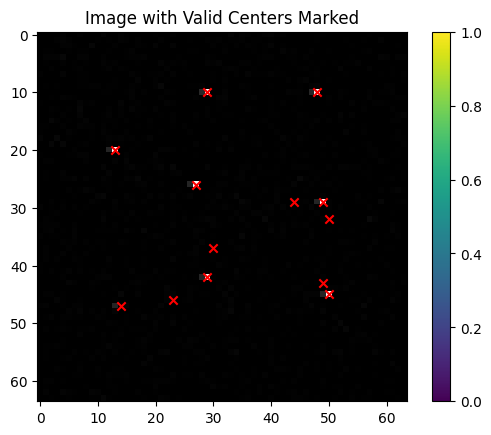

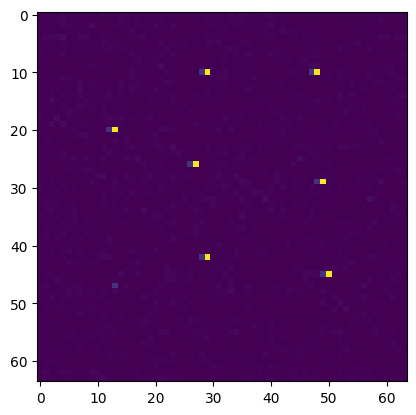

In [7]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l])

In [15]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


In [16]:

batch_size = 2000
train_dataset = train_dataset.shuffle(buffer_size=8000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=8000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (40000, 64, 64), Train Midpoints: (40000, 1, 13, 2)
Validation Images: (10000, 64, 64), Validation Midpoints: (10000, 1, 13, 2)


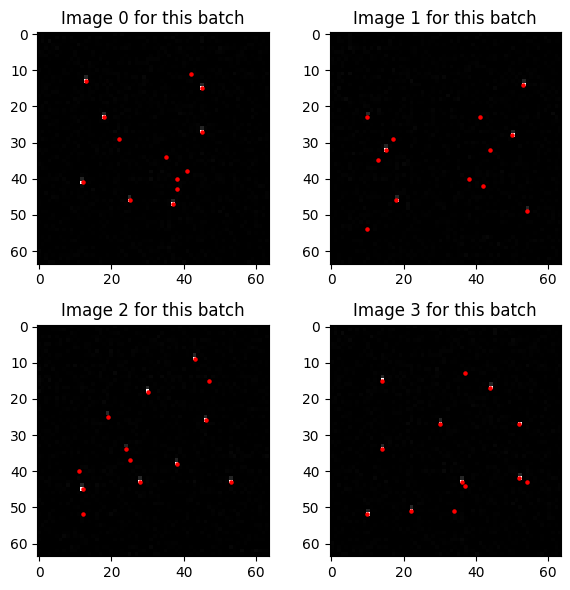

In [11]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [17]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='min', min_lr=3e-6
)


In [18]:

# dynamic_exponent_callback = DynamicExponentCallback(2, 1, 50)


with strategy.scope():
    # Instantiate the model builder
    # model_builder = ModelBuilder(weights_path= "/home/da886/Weights from Josh's model/Josh's5fixedMSE45overfit-1.keras")
    model_builder = ModelBuilder()

    # Build the model
    model_builder.build_model()

    # Display the model architecture
    model_builder.model.summary()

    # Compile the model using the custom loss function
    # model_builder.compile_model(loss_function=dynamic_exponent_callback.custom_loss(2))
    model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError()) 
    





Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 4, 4, 256)      │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 2, 2, 256)      │             

 Total params: 10,356,698 (39.51 MB)

 Trainable params: 10,352,218 (39.49 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [19]:

# Train the model with the custom callback
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=600,
    callbacks_list=[lr_scheduler]
)


Epoch 1/600


2024-10-06 19:03:30.493781: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-06 19:03:30.505966: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-06 19:03:30.539229: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1728241410.625364  562055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241410.625364  562049 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241410.627647  562057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241410.687106  562049 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241410.687106  562055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241410.687224  562057 gpu_timer.c

 1/20 ━━━━━━━━━━━━━━━━━━━━ 14:35 46s/step - loss: 2.2729

W0000 00:00:1728241438.590305  562050 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241438.599405  562050 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241438.622687  562050 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241438.623923  562050 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241438.626083  562050 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241438.629658  562050 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241438.632234  562050 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241438.635045  562050 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241438.637166  562050 gp

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 6.1299

2024-10-06 19:04:03.197965: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-06 19:04:03.198118: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-06 19:04:03.198302: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 5.9606

W0000 00:00:1728241447.240670  562042 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241447.241879  562042 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241447.243202  562042 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241447.244735  562042 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241447.244811  562012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241447.246092  562012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241447.246346  562042 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241447.246490  562007 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728241447.247965  562012 gp

20/20 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 5.8046 - val_loss: 1.3468 - learning_rate: 0.0010
Epoch 2/600


2024-10-06 19:04:26.705785: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.1443

2024-10-06 19:04:32.766207: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 322ms/step - loss: 0.1418 - val_loss: 0.7995 - learning_rate: 0.0010
Epoch 3/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - loss: 0.0773 - val_loss: 0.3163 - learning_rate: 0.0010
Epoch 4/600


2024-10-06 19:04:40.668424: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step - loss: 0.0578 - val_loss: 0.2391 - learning_rate: 0.0010
Epoch 5/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - loss: 0.0467 - val_loss: 0.2625 - learning_rate: 0.0010
Epoch 6/600
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.0398

2024-10-06 19:05:00.716017: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 311ms/step - loss: 0.0393 - val_loss: 0.7718 - learning_rate: 0.0010
Epoch 7/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - loss: 0.0339 - val_loss: 1.6664 - learning_rate: 0.0010
Epoch 8/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step - loss: 0.0300 - val_loss: 2.8506 - learning_rate: 0.0010
Epoch 9/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - loss: 0.0275 - val_loss: 4.3206 - learning_rate: 0.0010
Epoch 10/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - loss: 0.0253 - val_loss: 5.6536 - learning_rate: 0.0010
Epoch 11/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - loss: 0.0240 - val_loss: 6.4494 - learning_rate: 0.0010
Epoch 12/600


2024-10-06 19:05:36.221547: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - loss: 0.0232 - val_loss: 7.0968 - learning_rate: 0.0010
Epoch 13/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - loss: 0.0226 - val_loss: 7.7311 - learning_rate: 0.0010
Epoch 14/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.0222
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 423ms/step - loss: 0.0222 - val_loss: 7.9729 - learning_rate: 0.0010
Epoch 15/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - loss: 0.0219 - val_loss: 8.3002 - learning_rate: 9.0000e-04
Epoch 16/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - loss: 0.0217 - val_loss: 8.5892 - learning_rate: 9.0000e-04
Epoch 17/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - loss: 0.0215 - val_loss: 8.8608 - learning_rate: 9.0000e-04
Epoch 18/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 311ms/step - loss: 0.0214 - val_loss: 8.9663 - learning_rate: 9.0000e-04
Epoch 19/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - loss: 0.0214 - val_loss:

2024-10-06 19:06:52.503876: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 320ms/step - loss: 0.0213 - val_loss: 9.1173 - learning_rate: 9.0000e-04
Epoch 23/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - loss: 0.0213 - val_loss: 9.1371 - learning_rate: 9.0000e-04
Epoch 24/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.0213
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - loss: 0.0213 - val_loss: 9.0575 - learning_rate: 9.0000e-04
Epoch 25/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - loss: 0.0212 - val_loss: 8.8234 - learning_rate: 8.1000e-04
Epoch 26/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - loss: 0.0211 - val_loss: 8.8561 - learning_rate: 8.1000e-04
Epoch 27/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - loss: 0.0210 - val_loss: 8.8983 - learning_rate: 8.1000e-04
Epoch 28/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - loss: 0.0210 - val_loss: 8.6618 - learning_rate: 8.1000e-04
Epoch 29/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step - loss: 0.0210

2024-10-06 19:09:24.304166: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - loss: 0.0207 - val_loss: 0.0276 - learning_rate: 7.2900e-04
Epoch 45/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - loss: 0.0208 - val_loss: 0.0240 - learning_rate: 7.2900e-04
Epoch 46/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - loss: 0.0208 - val_loss: 0.0227 - learning_rate: 7.2900e-04
Epoch 47/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - loss: 0.0208 - val_loss: 0.0224 - learning_rate: 7.2900e-04
Epoch 48/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - loss: 0.0209 - val_loss: 0.0216 - learning_rate: 7.2900e-04
Epoch 49/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - loss: 0.0209 - val_loss: 0.0218 - learning_rate: 7.2900e-04
Epoch 50/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - loss: 0.0209 - val_loss: 0.0217 - learning_rate: 7.2900e-04
Epoch 51/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - loss: 0.0210 - val_loss: 0.0216 - learning_rate: 7.2900e-04
Epoch 52/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 313ms/step - loss: 0.0209 - val_loss: 0.0

2024-10-06 19:14:25.071207: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0205
Epoch 87: ReduceLROnPlateau reducing learning rate to 0.0005314410547725857.
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - loss: 0.0205 - val_loss: 0.0217 - learning_rate: 5.9049e-04
Epoch 88/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - loss: 0.0203 - val_loss: 0.0208 - learning_rate: 5.3144e-04
Epoch 89/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - loss: 0.0203 - val_loss: 0.0209 - learning_rate: 5.3144e-04
Epoch 90/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - loss: 0.0203 - val_loss: 0.0210 - learning_rate: 5.3144e-04
Epoch 91/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 317ms/step - loss: 0.0203 - val_loss: 0.0210 - learning_rate: 5.3144e-04
Epoch 92/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - loss: 0.0203 - val_loss: 0.0207 - learning_rate: 5.3144e-04
Epoch 93/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - loss: 0.0202 - val_loss: 0.0209 - learning_rate: 5.3144e-04
Epoch 94/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - loss: 0.0204

2024-10-06 19:24:12.960833: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - loss: 0.0195 - val_loss: 0.0207 - learning_rate: 2.5419e-04
Epoch 173/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - loss: 0.0196 - val_loss: 0.0205 - learning_rate: 2.5419e-04
Epoch 174/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - loss: 0.0195 - val_loss: 0.0208 - learning_rate: 2.5419e-04
Epoch 175/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - loss: 0.0195 - val_loss: 0.0206 - learning_rate: 2.5419e-04
Epoch 176/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - loss: 0.0194 - val_loss: 0.0208 - learning_rate: 2.5419e-04
Epoch 177/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0194
Epoch 177: ReduceLROnPlateau reducing learning rate to 0.00022876793809700757.
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - loss: 0.0195 - val_loss: 0.0212 - learning_rate: 2.5419e-04
Epoch 178/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - loss: 0.0194 - val_loss: 0.0206 - learning_rate: 2.2877e-04
Epoch 179/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - los

2024-10-06 19:43:39.628145: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - loss: 0.0143 - val_loss: 0.0244 - learning_rate: 4.2391e-05
Epoch 344/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 316ms/step - loss: 0.0142 - val_loss: 0.0237 - learning_rate: 4.2391e-05
Epoch 345/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - loss: 0.0142 - val_loss: 0.0240 - learning_rate: 4.2391e-05
Epoch 346/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step - loss: 0.0141 - val_loss: 0.0237 - learning_rate: 4.2391e-05
Epoch 347/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0140
Epoch 347: ReduceLROnPlateau reducing learning rate to 3.815204618149437e-05.
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - loss: 0.0141 - val_loss: 0.0238 - learning_rate: 4.2391e-05
Epoch 348/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - loss: 0.0139 - val_loss: 0.0236 - learning_rate: 3.8152e-05
Epoch 349/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - loss: 0.0139 - val_loss: 0.0243 - learning_rate: 3.8152e-05
Epoch 350/600
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - loss

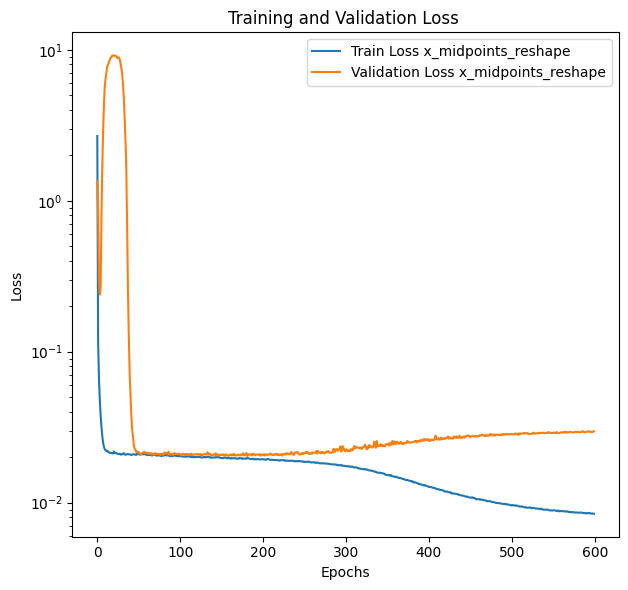

In [20]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
# model_builder.model.save("/home/da886/Analysis/13originalmodeloverfitLinearindex6.keras")
# loaded_model = tf.keras.models.load_model(
# "/home/da886/Final Electron counting project/Trained weights/Fixed weights/13overfitoriginalmodelgeneralized.keras",
# )

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title(title)

    # Plot midpoints directly, only if they are not (0, 0)
    for i, (x, y) in enumerate(midpoints_np):
        if x >= 3 and y >= 3:  # Only plot if the point is not (0, 0)
            plt.scatter(x, y, color='red', s=5)

    plt.show()

# Create the validation dataset
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(800)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)
# # Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# # Loop through each batch in the validation dataset, predict, and collect results
# for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions = model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Processing batch 2, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 3, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 4, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 5, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 6, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 7, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 8, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 9, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Processing batch 10, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 11, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 12, batch shape: (800, 64, 64)
25/2

In [15]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [22]:
all_images.shape,all_pred_midpoints.shape,all_true_midpoints.shape

((40000, 64, 64), (40000, 1, 13, 2), (40000, 1, 13, 2))

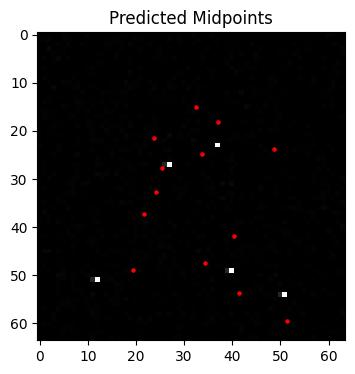

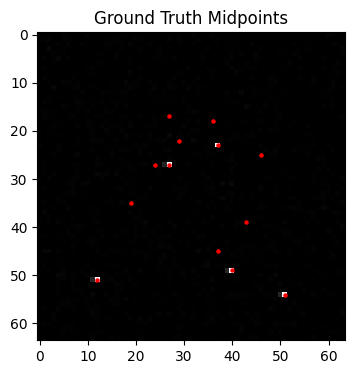

In [37]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * 64, title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * 64, title="Ground Truth Midpoints")


In [33]:
np.min(all_pred_midpoints),np.max(all_pred_midpoints)

(-0.10159277, 1.0629987)

In [34]:
np.min(all_true_midpoints),np.max(all_true_midpoints)

(0.13964641, 0.84375)

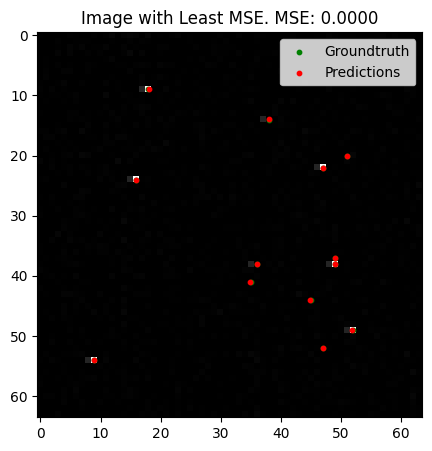

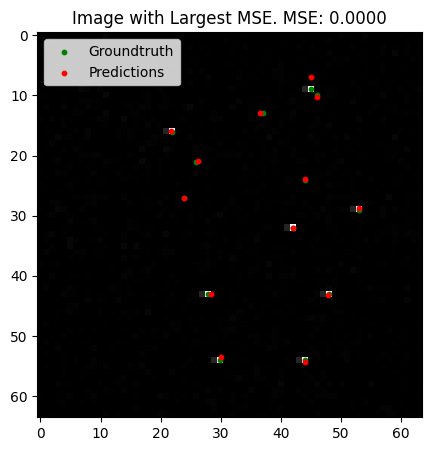

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) **2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')




In [263]:
max_mse_index

11548